In [5]:
from tensorflow.keras.datasets import mnist


In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()



In [7]:
print(X_train.shape)
print(y_train.shape)


(60000, 28, 28)
(60000,)


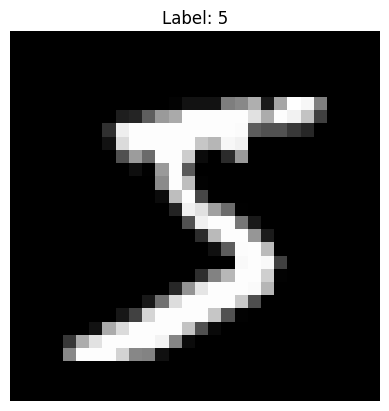

In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()


In [ ]:
This section loads the MNIST dataset and creates class imbalance.

In [9]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Digit {u}: {c} samples")



Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


In [11]:

idx_9 = np.where(y_train == 9)[0]

np.random.shuffle(idx_9)
idx_9 = idx_9[:500]

idx_others = np.where(y_train != 9)[0]

imbalanced_idx = np.concatenate([idx_others, idx_9])

X_imbalanced = X_train[imbalanced_idx]
y_imbalanced = y_train[imbalanced_idx]


In [12]:
unique, counts = np.unique(y_imbalanced, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Digit {u}: {c} samples")


Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 500 samples


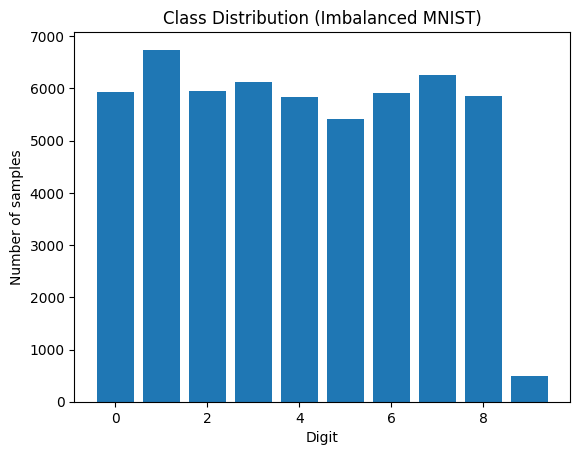

In [13]:
import matplotlib.pyplot as plt

plt.bar(unique, counts)
plt.xlabel("Digit")
plt.ylabel("Number of samples")
plt.title("Class Distribution (Imbalanced MNIST)")
plt.show()



In [ ]:
This section implements and trains a Vanilla GAN on the minority class.

In [14]:

X_minority = X_imbalanced[y_imbalanced == 9]
print(X_minority.shape)


(500, 28, 28)


In [15]:

X_minority = (X_minority.astype('float32') - 127.5) / 127.5


In [16]:
X_minority = np.expand_dims(X_minority, axis=-1)
print(X_minority.shape)


(500, 28, 28, 1)


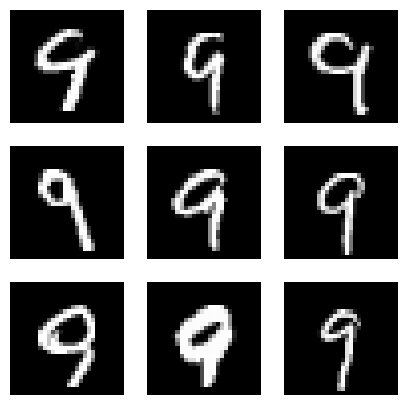

In [17]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_minority[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


In [19]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(28*28, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model


In [20]:
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28,28,1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(0.0002),
        metrics=['accuracy']
    )

    return model


In [21]:
generator = build_generator()
discriminator = build_discriminator()

discriminator.trainable = False

gan = models.Sequential([generator, discriminator])
gan.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(0.0002)
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
epochs = 2000
batch_size = 32

for epoch in range(epochs):


    idx = np.random.randint(0, X_minority.shape[0], batch_size)
    real_imgs = X_minority[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = generator.predict(noise, verbose=0)

    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))


    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D loss: {d_loss_real[0]:.4f} | G loss: {g_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D loss: 0.5891 | G loss: 0.8376
Epoch 200 | D loss: 3.7630 | G loss: 0.0215
Epoch 400 | D loss: 4.2532 | G loss: 0.0109
Epoch 600 | D loss: 4.5476 | G loss: 0.0073
Epoch 800 | D loss: 4.7660 | G loss: 0.0055
Epoch 1000 | D loss: 4.9356 | G loss: 0.0044
Epoch 1200 | D loss: 5.0782 | G loss: 0.0037
Epoch 1400 | D loss: 5.2008 | G loss: 0.0031
Epoch 1600 | D loss: 5.3089 | G loss: 0.0028
Epoch 1800 | D loss: 5.4055 | G loss: 0.0025


In [23]:
discriminator = build_discriminator()


In [24]:
discriminator.trainable = False


In [25]:
gan = models.Sequential([
    generator,
    discriminator
])

gan.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(0.0002)
)


In [26]:
epochs = 1000
batch_size = 32


In [27]:

X_imbalanced_norm = (X_imbalanced.astype('float32') - 127.5) / 127.5
X_imbalanced_norm = np.expand_dims(X_imbalanced_norm, axis=-1)

print(X_imbalanced_norm.shape)
print(y_imbalanced.shape)


(54551, 28, 28, 1)
(54551,)


In [28]:
from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_imbalanced_norm,
    y_imbalanced,
    test_size=0.2,
    random_state=42,
    stratify=y_imbalanced
)


In [ ]:
This section trains a CNN classifier on the imbalanced and balanced datasets.

In [29]:
def build_classifier():
    model = models.Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [30]:
classifier_imbalanced = build_classifier()

history_imbalanced = classifier_imbalanced.fit(
    X_train_c,
    y_train_c,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.8701 - loss: 0.4317 - val_accuracy: 0.9817 - val_loss: 0.0685
Epoch 2/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9834 - loss: 0.0547 - val_accuracy: 0.9840 - val_loss: 0.0522
Epoch 3/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9903 - loss: 0.0315 - val_accuracy: 0.9833 - val_loss: 0.0524
Epoch 4/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9930 - loss: 0.0230 - val_accuracy: 0.9874 - val_loss: 0.0359
Epoch 5/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9950 - loss: 0.0159 - val_accuracy: 0.9899 - val_loss: 0.0351


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(classifier_imbalanced.predict(X_test_c), axis=1)

print(classification_report(y_test_c, y_pred))


341/341 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       1.00      0.99      0.99      1349
           2       0.98      0.99      0.99      1192
           3       0.98      0.99      0.99      1226
           4       0.99      0.99      0.99      1168
           5       0.99      0.98      0.99      1084
           6       0.99      0.98      0.99      1184
           7       0.99      0.99      0.99      1253
           8       0.98      0.99      0.98      1170
           9       0.97      0.89      0.93       100

    accuracy                           0.99     10911
   macro avg       0.99      0.98      0.98     10911
weighted avg       0.99      0.99      0.99     10911



In [32]:
num_fake = 5000

noise = np.random.normal(0, 1, (num_fake, 100))
fake_images = generator.predict(noise, verbose=0)

fake_images = (fake_images + 1) / 2


In [33]:
fake_labels = np.ones(num_fake, dtype=int) * 9


In [34]:

X_real = X_imbalanced_norm
y_real = y_imbalanced


X_balanced = np.concatenate([X_real, fake_images], axis=0)
y_balanced = np.concatenate([y_real, fake_labels], axis=0)

print(X_balanced.shape)
print(y_balanced.shape)


(59551, 28, 28, 1)
(59551,)


In [35]:
unique, counts = np.unique(y_balanced, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Digit {u}: {c} samples")


Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5500 samples


In [36]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)


In [37]:
classifier_gan = build_classifier()

history_gan = classifier_gan.fit(
    X_train_b,
    y_train_b,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5
670/670 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.8885 - loss: 0.3722 - val_accuracy: 0.9813 - val_loss: 0.0656
Epoch 2/5
670/670 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9847 - loss: 0.0484 - val_accuracy: 0.9855 - val_loss: 0.0435
Epoch 3/5
670/670 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.9922 - loss: 0.0259 - val_accuracy: 0.9885 - val_loss: 0.0410
Epoch 4/5
670/670 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.9935 - loss: 0.0189 - val_accuracy: 0.9906 - val_loss: 0.0297
Epoch 5/5
670/670 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9955 - loss: 0.0139 - val_accuracy: 0.9914 - val_loss: 0.0311


In [38]:
y_pred_gan = np.argmax(classifier_gan.predict(X_test_b), axis=1)

print(classification_report(y_test_b, y_pred_gan))


373/373 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1185
           1       0.99      0.99      0.99      1349
           2       0.99      0.98      0.99      1192
           3       0.99      0.99      0.99      1226
           4       1.00      0.99      0.99      1168
           5       0.99      0.99      0.99      1084
           6       0.99      0.99      0.99      1184
           7       0.98      1.00      0.99      1253
           8       0.99      0.98      0.98      1170
           9       1.00      0.99      0.99      1100

    accuracy                           0.99     11911
   macro avg       0.99      0.99      0.99     11911
weighted avg       0.99      0.99      0.99     11911



In [39]:
X_dcgan = X_minority
print(X_dcgan.shape)


(500, 28, 28, 1)


In [ ]:
This section implements DCGAN as an advanced GAN variant.

In [40]:
def build_dcgan_generator():
    model = models.Sequential()
    model.add(layers.Input(shape=(100,)))
    model.add(layers.Dense(7*7*128))
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(1, kernel_size=7, activation='tanh', padding='same'))
    return model


In [41]:
def build_dcgan_discriminator():
    model = models.Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.Adam(0.0002),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [42]:
dcgan_generator = build_dcgan_generator()
dcgan_discriminator = build_dcgan_discriminator()

dcgan_discriminator.trainable = False

dcgan = models.Sequential([
    dcgan_generator,
    dcgan_discriminator
])

dcgan.compile(
    optimizer=optimizers.Adam(0.0002),
    loss='binary_crossentropy'
)


In [43]:
epochs = 1500
batch_size = 32

for epoch in range(epochs):
    idx = np.random.randint(0, X_dcgan.shape[0], batch_size)
    real_imgs = X_dcgan[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = dcgan_generator.predict(noise, verbose=0)

    dcgan_discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    dcgan_discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))

    noise = np.random.normal(0, 1, (batch_size, 100))
    dcgan.train_on_batch(noise, np.ones((batch_size, 1)))

    if epoch % 300 == 0:
        print(f"Epoch {epoch}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0
Epoch 300
Epoch 600
Epoch 900
Epoch 1200


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


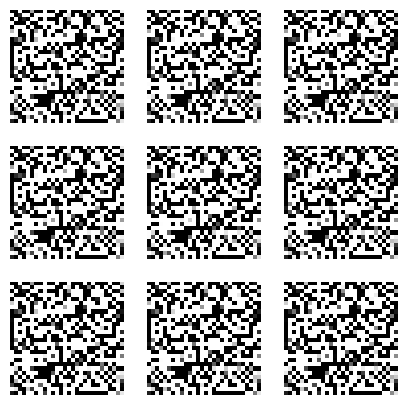

In [44]:
noise = np.random.normal(0, 1, (9, 100))
dcgan_images = dcgan_generator.predict(noise)
dcgan_images = (dcgan_images + 1) / 2

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(dcgan_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()
